In [1]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

import numpy as np
import torch
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML

import pandas as pd

from tqdm import tqdm

In [2]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [3]:
df = pd.read_csv('generated_images/clip_mlp_activations.csv')
df

,filename,mean_0_0,max_0_0,mean_0_1,max_0_1,mean_0_2,max_0_2,mean_0_3,max_0_3,mean_0_4,...,mean_23_1019,max_23_1019,mean_23_1020,max_23_1020,mean_23_1021,max_23_1021,mean_23_1022,max_23_1022,mean_23_1023,max_23_1023
0,generated_images/image_1_shapes_0.png,0.099164,0.257024,0.298203,0.333471,0.059541,0.090624,0.108643,0.212754,0.022055,...,-0.171294,0.034744,0.227626,0.437658,-0.130334,0.179163,-0.228286,0.008854,-0.119478,0.226579
1,generated_images/image_1_shapes_1.png,0.098868,0.236394,0.298659,0.333518,0.059578,0.093828,0.108109,0.198275,0.022334,...,-0.159002,0.128170,0.228707,0.454122,-0.121280,0.225495,-0.221970,0.040223,-0.119355,0.224534
2,generated_images/image_1_shapes_2.png,0.098371,0.198219,0.294899,0.335975,0.057270,0.078525,0.102543,0.166103,0.021096,...,-0.183971,0.081780,0.185437,0.404024,-0.099349,0.141499,-0.227266,-0.016253,-0.099449,0.229580
3,generated_images/image_1_shapes_3.png,0.105667,0.350031,0.310025,0.336265,0.058159,0.078626,0.111158,0.305242,0.023447,...,-0.175808,0.136730,0.170698,0.396673,-0.065466,0.173172,-0.210550,0.142581,-0.052900,0.315388
4,generated_images/image_1_shapes_4.png,0.102984,0.147678,0.304164,0.331992,0.063006,0.108819,0.106660,0.195209,0.021967,...,-0.175748,0.019588,0.204655,0.394590,-0.124101,0.192931,-0.233677,-0.016928,-0.109357,0.350109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,generated_images/image_5_shapes_95.png,0.102451,0.214196,0.264764,0.334364,0.047601,0.123497,0.108762,0.324152,0.021233,...,-0.142009,0.198176,0.214031,0.480671,-0.096051,0.227638,-0.217189,0.180153,-0.043028,0.357173
496,generated_images/image_5_shapes_96.png,0.099824,0.218822,0.254907,0.332797,0.048234,0.107941,0.103577,0.216401,0.023336,...,-0.147976,0.131034,0.200914,0.431632,-0.085056,0.267447,-0.210242,0.221128,-0.054774,0.284328
497,generated_images/image_5_shapes_97.png,0.099764,0.249264,0.256887,0.336022,0.047266,0.098838,0.109927,0.263641,0.019197,...,-0.151952,0.087928,0.201548,0.435799,-0.080965,0.278892,-0.212384,0.200994,-0.059827,0.318426
498,generated_images/image_5_shapes_98.png,0.101962,0.418774,0.262032,0.412612,0.047812,0.127314,0.110888,0.263006,0.021316,...,-0.147790,0.160468,0.201102,0.431684,-0.064188,0.318274,-0.208776,0.170633,-0.040669,0.427834


In [4]:
def filter(row):
    filename = row['filename']
    num_shapes = [1, 2, 3, 4, 5]
    for num_shape in num_shapes:
        if f'_{num_shape}_' in filename:
            return True

    return False

In [5]:
activations_df = df[df.apply(filter, axis=1)]
activations_df

,filename,mean_0_0,max_0_0,mean_0_1,max_0_1,mean_0_2,max_0_2,mean_0_3,max_0_3,mean_0_4,...,mean_23_1019,max_23_1019,mean_23_1020,max_23_1020,mean_23_1021,max_23_1021,mean_23_1022,max_23_1022,mean_23_1023,max_23_1023
0,generated_images/image_1_shapes_0.png,0.099164,0.257024,0.298203,0.333471,0.059541,0.090624,0.108643,0.212754,0.022055,...,-0.171294,0.034744,0.227626,0.437658,-0.130334,0.179163,-0.228286,0.008854,-0.119478,0.226579
1,generated_images/image_1_shapes_1.png,0.098868,0.236394,0.298659,0.333518,0.059578,0.093828,0.108109,0.198275,0.022334,...,-0.159002,0.128170,0.228707,0.454122,-0.121280,0.225495,-0.221970,0.040223,-0.119355,0.224534
2,generated_images/image_1_shapes_2.png,0.098371,0.198219,0.294899,0.335975,0.057270,0.078525,0.102543,0.166103,0.021096,...,-0.183971,0.081780,0.185437,0.404024,-0.099349,0.141499,-0.227266,-0.016253,-0.099449,0.229580
3,generated_images/image_1_shapes_3.png,0.105667,0.350031,0.310025,0.336265,0.058159,0.078626,0.111158,0.305242,0.023447,...,-0.175808,0.136730,0.170698,0.396673,-0.065466,0.173172,-0.210550,0.142581,-0.052900,0.315388
4,generated_images/image_1_shapes_4.png,0.102984,0.147678,0.304164,0.331992,0.063006,0.108819,0.106660,0.195209,0.021967,...,-0.175748,0.019588,0.204655,0.394590,-0.124101,0.192931,-0.233677,-0.016928,-0.109357,0.350109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,generated_images/image_5_shapes_95.png,0.102451,0.214196,0.264764,0.334364,0.047601,0.123497,0.108762,0.324152,0.021233,...,-0.142009,0.198176,0.214031,0.480671,-0.096051,0.227638,-0.217189,0.180153,-0.043028,0.357173
496,generated_images/image_5_shapes_96.png,0.099824,0.218822,0.254907,0.332797,0.048234,0.107941,0.103577,0.216401,0.023336,...,-0.147976,0.131034,0.200914,0.431632,-0.085056,0.267447,-0.210242,0.221128,-0.054774,0.284328
497,generated_images/image_5_shapes_97.png,0.099764,0.249264,0.256887,0.336022,0.047266,0.098838,0.109927,0.263641,0.019197,...,-0.151952,0.087928,0.201548,0.435799,-0.080965,0.278892,-0.212384,0.200994,-0.059827,0.318426
498,generated_images/image_5_shapes_98.png,0.101962,0.418774,0.262032,0.412612,0.047812,0.127314,0.110888,0.263006,0.021316,...,-0.147790,0.160468,0.201102,0.431684,-0.064188,0.318274,-0.208776,0.170633,-0.040669,0.427834


In [6]:
image_paths = [
    "generated_images/image_2_shapes_18.png", 
    "generated_images/image_3_shapes_24.png", 
    # "generated_images/image_4_shapes_9.png"
]

image_paths = [
    "generated_images/image_2_shapes_0.png",
    "generated_images/image_2_shapes_74.png",
]

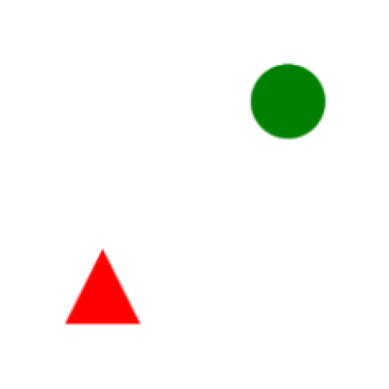

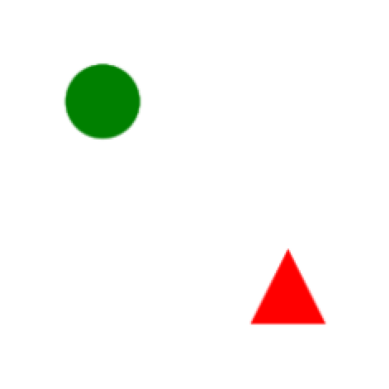

In [7]:
for image_path in image_paths:
    image = Image.open(image_path)
    image = transform(image)
    plot_image(image)

In [8]:
sub_df = activations_df[activations_df['filename'].isin(image_paths)]
sub_df

,filename,mean_0_0,max_0_0,mean_0_1,max_0_1,mean_0_2,max_0_2,mean_0_3,max_0_3,mean_0_4,...,mean_23_1019,max_23_1019,mean_23_1020,max_23_1020,mean_23_1021,max_23_1021,mean_23_1022,max_23_1022,mean_23_1023,max_23_1023
100,generated_images/image_2_shapes_0.png,0.099669,0.225491,0.288006,0.336193,0.054995,0.087820,0.108882,0.180530,0.022738,...,-0.195029,0.081831,0.211708,0.466022,-0.102949,0.179571,-0.239522,0.066270,-0.103159,0.238476
174,generated_images/image_2_shapes_74.png,0.099885,0.228685,0.288349,0.334038,0.054979,0.095603,0.109224,0.183526,0.022562,...,-0.190837,0.077332,0.216207,0.446929,-0.108422,0.243937,-0.240837,0.032691,-0.119949,0.238987


In [9]:
mode = 'mean'

In [10]:
# Identify neurons that are activated the most by the images

neuron_set = set()
top_k = 10
for i in range(len(sub_df)):
    image_activations = list(sub_df.iloc[i, 1:].items())
    image_activations = [(name, value) for name, value in image_activations if mode in name]
    image_activations.sort(key=lambda x: x[1], reverse=True)

    neuron_set_curr = set()
    for j in range(top_k):
        neuron_set_curr.add(image_activations[j][0])   

    if len(neuron_set) == 0:
        neuron_set = neuron_set_curr
    else:
        neuron_set = neuron_set.intersection(neuron_set_curr)

In [11]:
len(neuron_set)

9

In [12]:
print(neuron_set)

{'mean_20_715', 'mean_2_565', 'mean_23_121', 'mean_21_437', 'mean_21_200', 'mean_23_437', 'mean_22_565', 'mean_12_650', 'mean_5_565'}


Neuron: mean_20_715


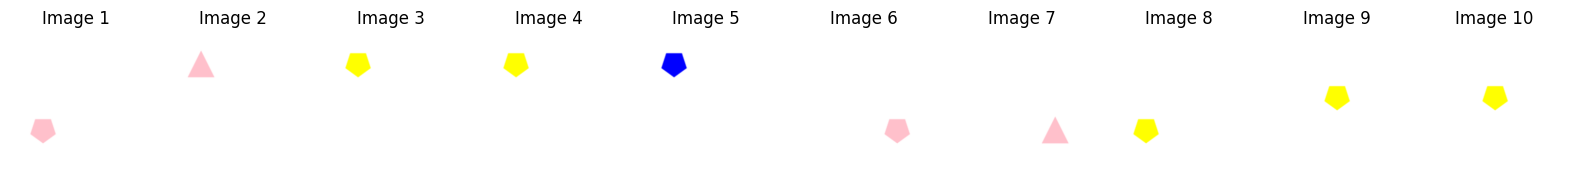

Neuron: mean_2_565


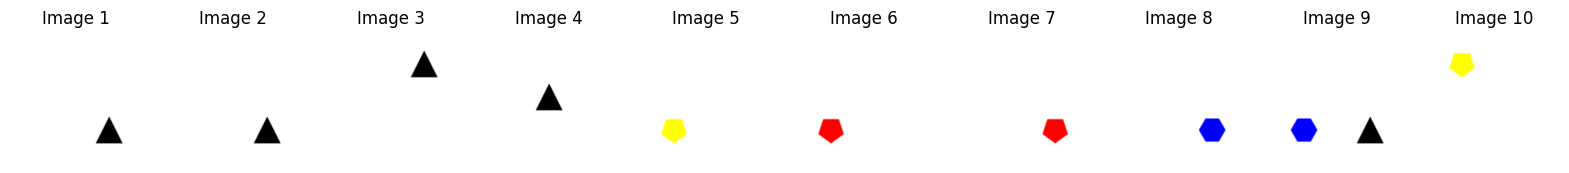

Neuron: mean_23_121


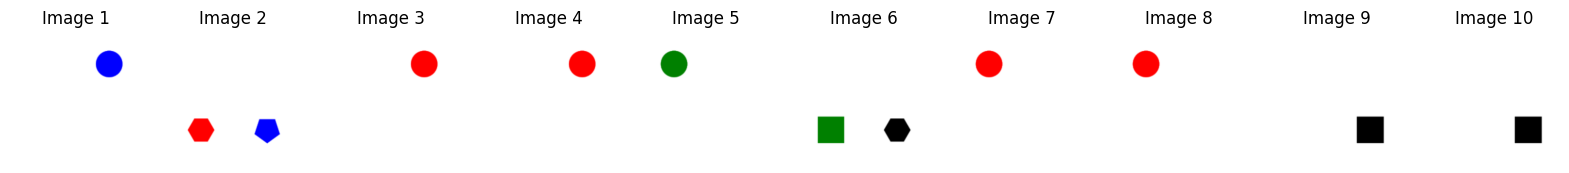

Neuron: mean_21_437


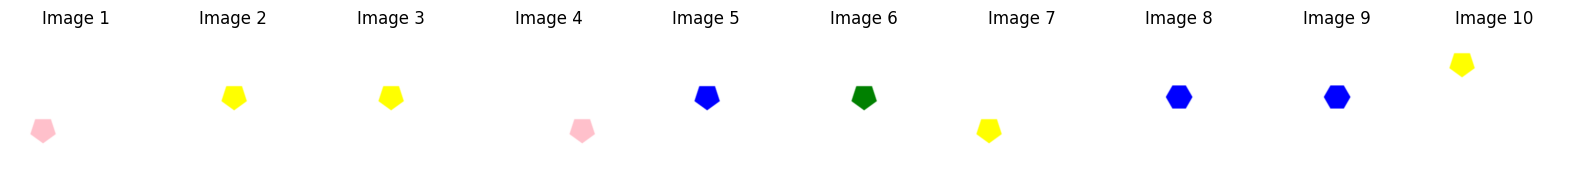

Neuron: mean_21_200


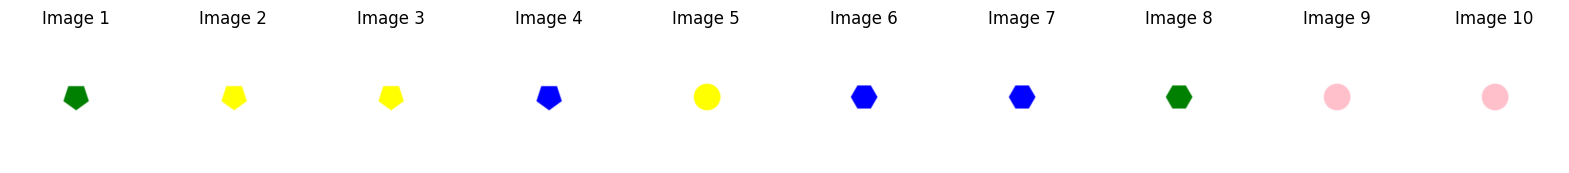

Neuron: mean_23_437


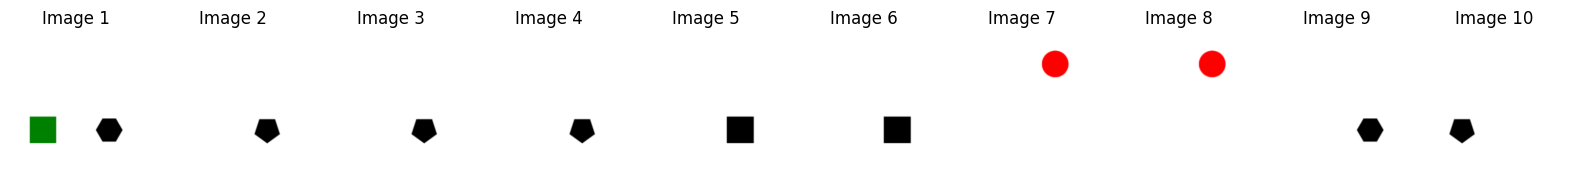

Neuron: mean_22_565


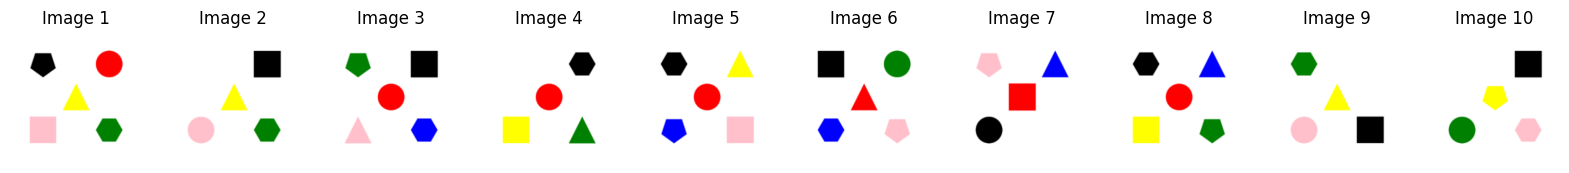

Neuron: mean_12_650


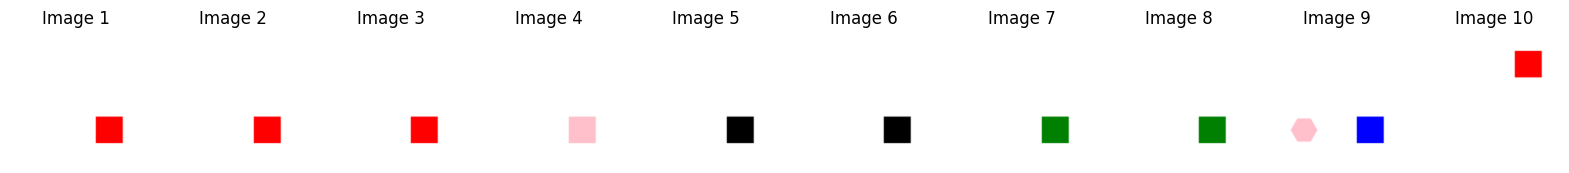

Neuron: mean_5_565


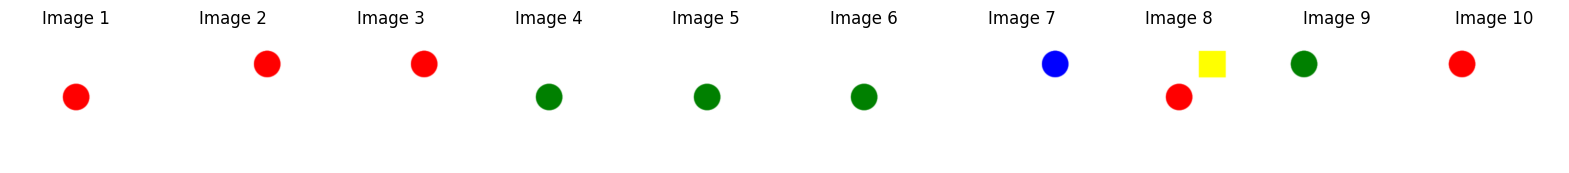

In [13]:
for neuron_name in neuron_set:
    # find images that activate this neuron the most
    top_k = 10
    top_images = []
    
    activations = list(activations_df[neuron_name].items())
    activations.sort(key=lambda x: x[1], reverse=True)


    for i in range(top_k):
        row_idx = activations[i][0]
        image_path = activations_df.iloc[row_idx]['filename']
        top_images.append(image_path)


    # Plot the images in a row
    fig, axs = plt.subplots(1, top_k, figsize=(20, 20))
    print(f"Neuron: {neuron_name}")
    for i in range(top_k):
        image = Image.open(top_images[i])
        image = transform(image)
        axs[i].imshow(image.permute(1,2,0))
        axs[i].axis('off')
        axs[i].set_title(f"Image {i+1}")
    plt.show()
    


Neuron: mean_22_565


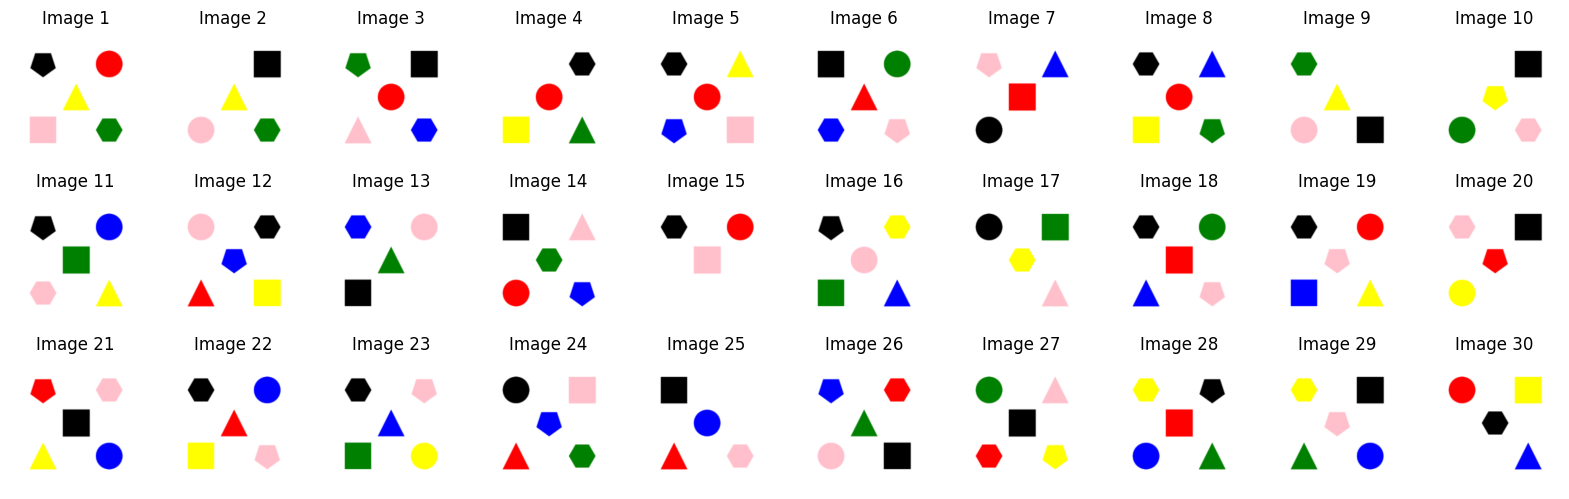

In [15]:
# neuron_name = 'mean_5_565' # Circle, Hexagon, Pentagon? coz, no triangles at all, and only 1 square image
# neuron_name = 'mean_12_650' # Square and Triangle? 25/30 images are square and triangle and the ones that are not are down the list
neuron_name = 'mean_22_565' # Many shape neuron?
# neuron_name = 'mean_21_437' # pentagon, hexagon, circle again?
# neuron_name = 'mean_23_437' # Red and Black?
# neuron_name = 'mean_21_200' # Middle position and Pentagon? every image satisfies
# find images that activate this neuron the most
top_k = 30
top_images = []

activations = list(activations_df[neuron_name].items())
activations.sort(key=lambda x: x[1], reverse=True)


for i in range(top_k):
    row_idx = activations[i][0]
    image_path = activations_df.iloc[row_idx]['filename']
    top_images.append(image_path)


# Plot the images in a row
fig, axs = plt.subplots(3, 10, figsize=(20, 6))
axs = axs.flatten()
print(f"Neuron: {neuron_name}")
for i in range(top_k):
    image = Image.open(top_images[i])
    image = transform(image)
    axs[i].imshow(image.permute(1,2,0))
    axs[i].axis('off')
    axs[i].set_title(f"Image {i+1}")
plt.show()